# EDA – STATISTICS

#### Load the dataset and perform basic data preprocessing

In [ ]:
import re
import csv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem as Chem
import rdkit.Chem.Lipinski as lp
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.SaltRemover import SaltRemover


from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import manifold

from scipy.spatial import distance


In [661]:
DATA = "CHEMBL301_ic50.csv"
pd.set_option("display.max_columns",None)

Load the data as a pandas DataFrame object. Drop duplicate smiles to not distort the statistical visualizations

In [662]:
chembl = pd.read_csv(DATA,delimiter=";")
chembl.drop_duplicates(subset="Smiles",inplace=True)

Remove blank smiles strings

In [663]:
print("Dataset shape: ", chembl.shape)
print("--------------------------------------------------------------------------------------")
print(chembl.info())
chembl = chembl.dropna(subset="Smiles")

Dataset shape:  (2545, 48)
--------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2545 entries, 0 to 3103
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          2545 non-null   object 
 1   Molecule Name               163 non-null    object 
 2   Molecule Max Phase          58 non-null     float64
 3   Molecular Weight            2545 non-null   float64
 4   #RO5 Violations             2537 non-null   float64
 5   AlogP                       2537 non-null   float64
 6   Compound Key                2545 non-null   object 
 7   Smiles                      2544 non-null   object 
 8   Standard Type               2545 non-null   object 
 9   Standard Relation           2508 non-null   object 
 10  Standard Value              2508 non-null   float64
 11  Standard Units              2510 non-n

Get both IDs and structures of the ligands.

In [664]:
ligand_ids = [id for _,id in chembl["Molecule ChEMBL ID"].items()]
ligand_mols = [Chem.MolFromSmiles(smiles) for _,smiles in chembl["Smiles"].items()]
len(ligand_mols)

2544

#### INVESTIGATE MOLECULAR DESCRIPTORS

Create a 3x2 subplot object, then populate it with corresponding visualizations – histograms representing the distribution of heavy atom counts, molar weights, H bond donors and acceptors, total polar surface area and logP. By carefully inspecting the referenced histograms, we can identify a few outliers using logP and TPSA histograms – these outliers correspond to tremendously polar ligands.

Text(0.5, 1.0, 'Distribution of logP')

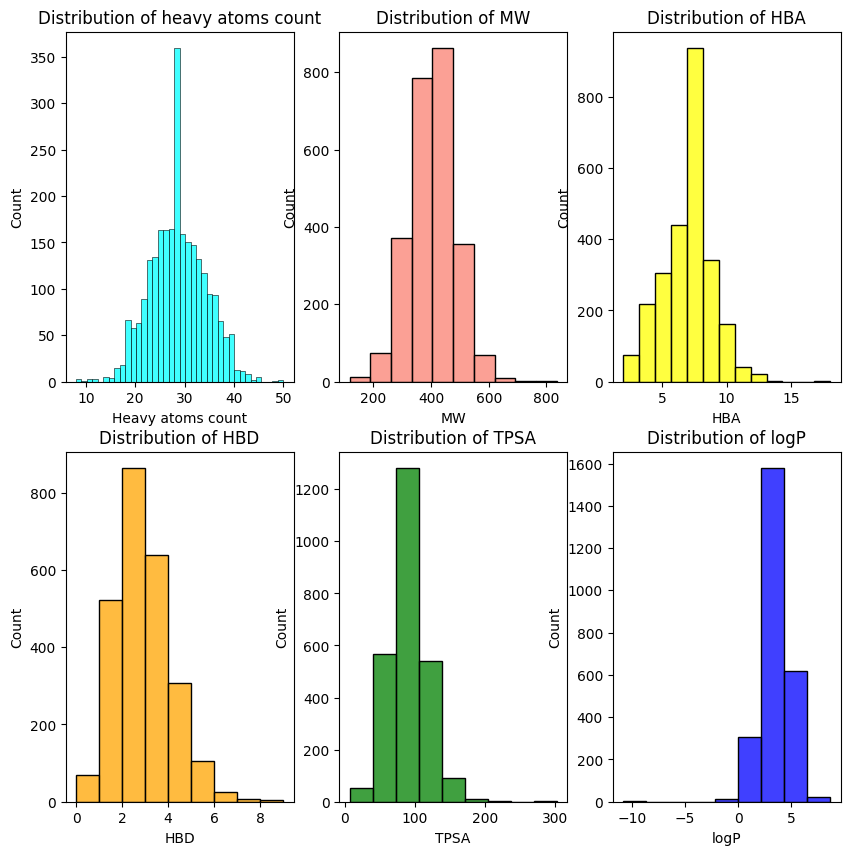

In [247]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
axes = axes.flatten()

ligand_heavy_atoms = [Descriptors.HeavyAtomCount(ligand) for ligand in ligand_mols]
ligand_mws = [rdescriptors.CalcExactMolWt(ligand) for ligand in ligand_mols]
ligand_hba = [rdescriptors.CalcNumLipinskiHBA(ligand) for ligand in ligand_mols]
ligand_hbd = [rdescriptors.CalcNumLipinskiHBD(ligand) for ligand in ligand_mols]
ligand_tpsa = [rdescriptors.CalcTPSA(ligand) for ligand in ligand_mols]
ligand_logp = [Descriptors.MolLogP(ligand) for ligand in ligand_mols]

sns.histplot(pd.DataFrame({"Heavy atoms count":ligand_heavy_atoms}),x="Heavy atoms count",bins=len(np.unique(ligand_heavy_atoms)) - 1,color="aqua",ax=axes[0])
sns.histplot(pd.DataFrame({"MW":ligand_mws}),x="MW",bins=10,color="salmon",ax=axes[1])
sns.histplot(pd.DataFrame({"HBA":ligand_hba}),x="HBA",bins=len(np.unique(ligand_hba)) - 1,color="yellow",ax=axes[2])
sns.histplot(pd.DataFrame({"HBD":ligand_hbd}),x="HBD",bins=len(np.unique(ligand_hbd)) - 1,color="orange",ax=axes[3])
sns.histplot(pd.DataFrame({"TPSA":ligand_tpsa}),x="TPSA",bins=10 - 1,color="green",ax=axes[4])
sns.histplot(pd.DataFrame({"logP":ligand_logp}),x="logP",bins=10 - 1,color="blue",ax=axes[5])

axes[0].set_title("Distribution of heavy atoms count")
axes[1].set_title("Distribution of MW")
axes[2].set_title("Distribution of HBA")
axes[3].set_title("Distribution of HBD")
axes[4].set_title("Distribution of TPSA")
axes[5].set_title("Distribution of logP")

Let's have a look at some of the molecules defined above as outliers. Judging by the nature of characteristic bond in the case of belowmentioned sodium salts and by experience in a wet lab working with diazacompounds I doubt these could prove to be promising drug candidates.

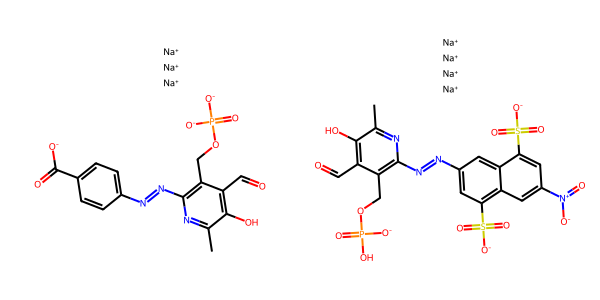

In [679]:
outliers = [mol for logp,tpsa,mol in zip(ligand_logp, ligand_tpsa,ligand_mols) if logp < -1 and tpsa > 180]
Draw.MolsToGridImage(outliers, molsPerRow=2, subImgSize=(300,300))

Define Lipinski rule of five and sort out only compounds not following these rules.

In [248]:
ligands_too_many_hbd = [rdescriptors.CalcNumLipinskiHBD(l) > 5 for l in ligand_mols]
ligands_too_many_hba = [rdescriptors.CalcNumLipinskiHBA(l) > 10 for l in ligand_mols]
ligands_too_heavy = [rdescriptors.CalcExactMolWt(l) > 500 for l in ligand_mols]
ligands_too_greasy = [Descriptors.MolLogP(l) > 5 for l in ligand_mols]

In [249]:
violations_df = pd.DataFrame(data={'too_many_hbd': ligands_too_many_hbd,
                        'too_many_hba': ligands_too_many_hba,
                        'too_greasy': ligands_too_greasy,
                        'too_heavy': ligands_too_heavy})

As depicted below, the number of compounds not obeying LROF is merely a small fraction of the entire dataset.

Text(0, 0.5, 'Ratio of issues in set')

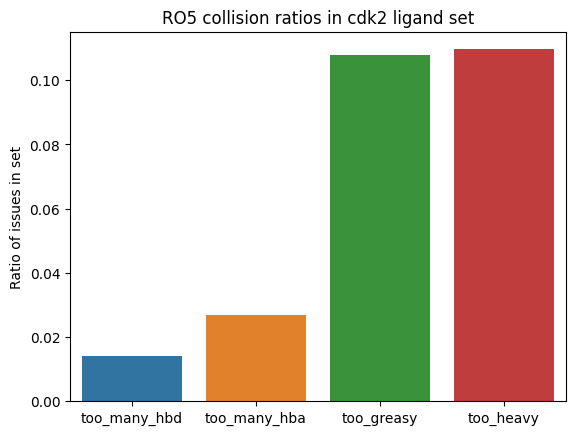

In [665]:
p = sns.barplot(data=violations_df, errorbar=None)
p.set_title("RO5 collision ratios in cdk2 ligand set")
p.set_ylabel("Ratio of issues in set")

Let's explore how much do these LROF breaches overlap – meaning how many molecules do not follow multiple LROF. As for an example, let's calculate the percentage of too heavy ligands that disobey at least one more LROF.

In [251]:
print(f"Total {violations_df[violations_df["too_greasy"] & violations_df["too_heavy"]].shape[0] / sum(violations_df["too_heavy"]) * 100} % of too heavy ligands are ligands with logP > 5")
print(f"Total {violations_df[violations_df["too_many_hbd"] & violations_df["too_heavy"] & ~violations_df["too_greasy"]].shape[0] / sum(violations_df["too_heavy"]) * 100} % of too heavy ligands and ligands with logP < 5 are ligands with HBD > 5")
print(f"Total {violations_df[violations_df["too_many_hba"] & violations_df["too_heavy"] & ~violations_df["too_greasy"]].shape[0] / sum(violations_df["too_heavy"]) * 100} % of too heavy ligands and ligands with logP < 5 are ligands with HBA > 10")
print(f"In total {violations_df[violations_df["too_greasy"] & violations_df["too_heavy"]].shape[0] / sum(violations_df["too_heavy"]) * 100 + \
                  violations_df[violations_df["too_many_hbd"] & violations_df["too_heavy"] & ~violations_df["too_greasy"]].shape[0] / sum(violations_df["too_heavy"]) * 100 + \
                  violations_df[violations_df["too_many_hba"] & violations_df["too_heavy"] & ~violations_df["too_greasy"]].shape[0] / sum(violations_df["too_heavy"]) * 100} % of too heavy ligands have at least one more violation of ROF")

Total 36.55913978494624 % of too heavy ligands are ligands with logP > 5
Total 4.301075268817205 % of too heavy ligands and ligands with logP < 5 are ligands with HBD > 5
Total 15.412186379928317 % of too heavy ligands and ligands with logP < 5 are ligands with HBA > 10
In total 56.27240143369176 % of too heavy ligands have at least one more violation of ROF


Using violin plots (can be thought of as box plots with distribution estimate) it is possible to also easily identify outliers by observing long tails of each violin plot.

<Axes: >

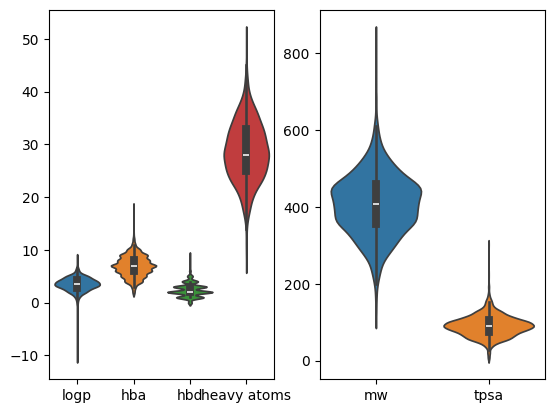

In [252]:
fig,axes = plt.subplots(1,2)
axes = axes.flatten()

sns.violinplot(data=pd.DataFrame({"logp":ligand_logp,"hba":ligand_hba,"hbd":ligand_hbd,"heavy atoms":ligand_heavy_atoms}),ax=axes[0])
sns.violinplot(data=pd.DataFrame({"mw":ligand_mws,"tpsa":ligand_tpsa}),ax=axes[1])

A different look into the data can be done using pairplots, where each scatterplot represents the dependence of two distinct descriptors whereas the histograms present on the diagonal represent the distribution of the corresponding descriptor. It is possible to identify a correlation of a pair of descriptors such is the case of HBA and HBD respectivelly with TPSA. Also note the presence of two outliers present in the first row. These are the diazasalts rendered before.

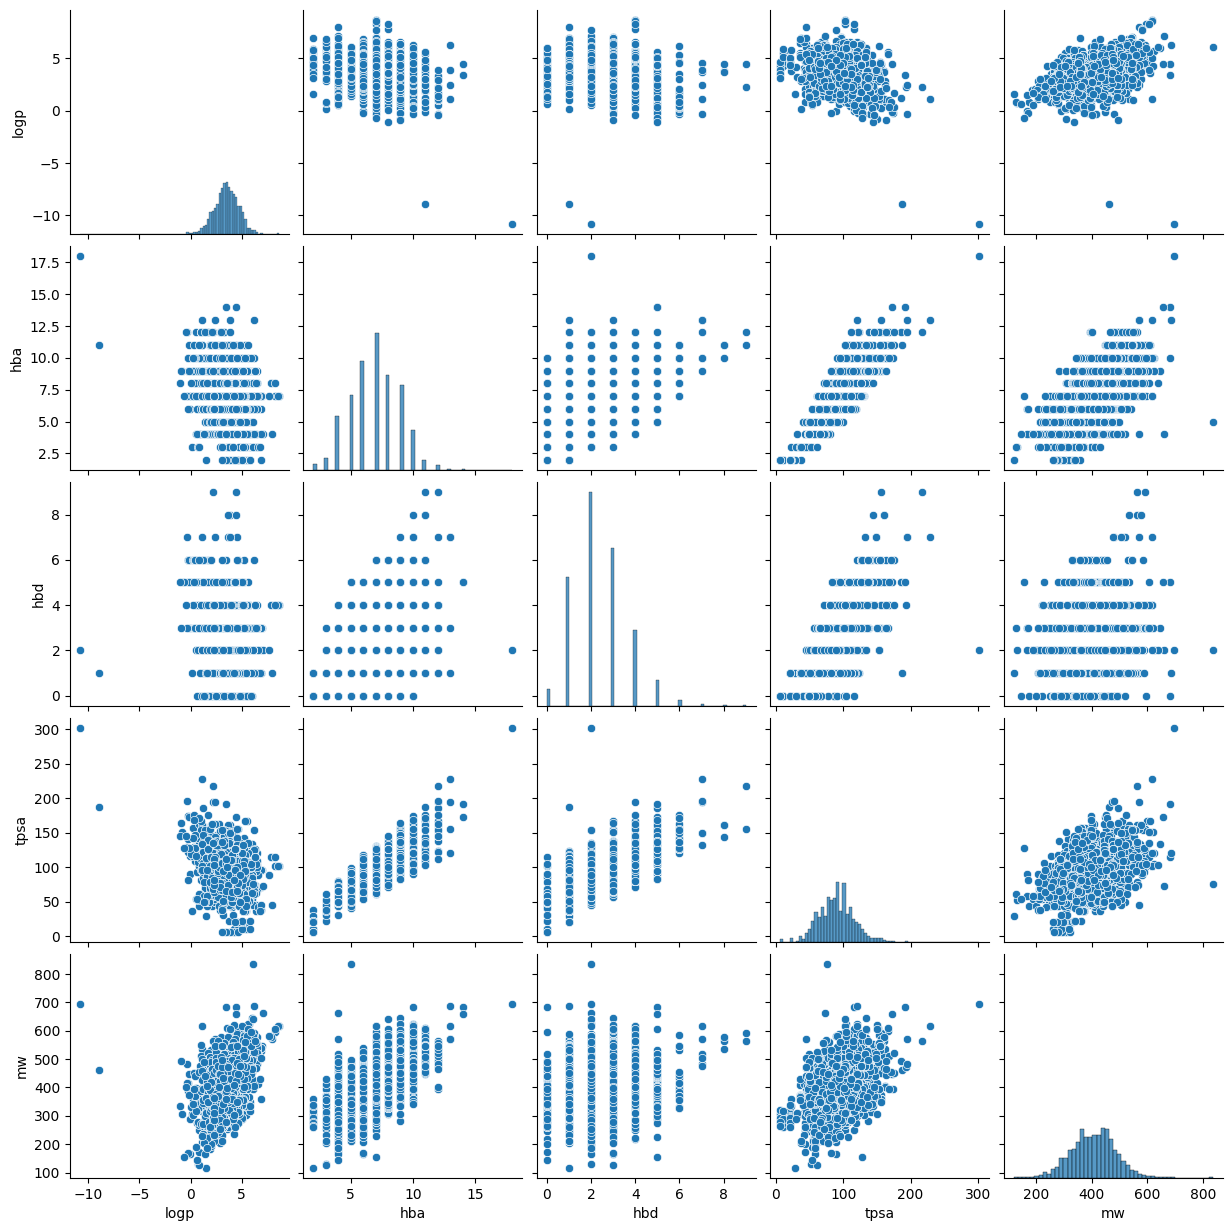

In [253]:
sns.pairplot(data=pd.DataFrame({"logp":ligand_logp,"hba":ligand_hba,"hbd":ligand_hbd,"tpsa":ligand_tpsa,"mw":ligand_mws}))

As already mentioned before, the great positive correlation of HBA (HBD) with TPSA is highlighted also in this simple heatmap.

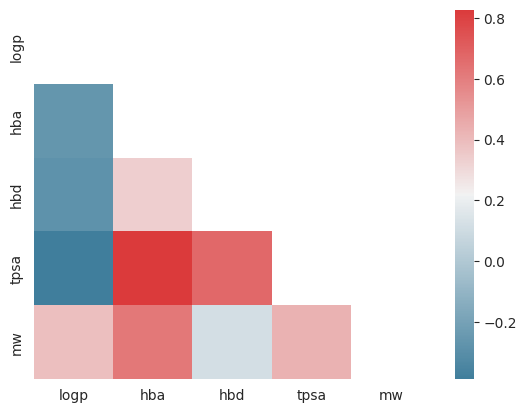

In [684]:
corr = pd.DataFrame({"logp":ligand_logp,"hba":ligand_hba,"hbd":ligand_hbd,"tpsa":ligand_tpsa,"mw":ligand_mws}).corr()
cmap = sns.diverging_palette(230,12, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
with sns.axes_style("white"):
    sns.heatmap(data=corr,cmap=cmap,mask=mask)

# SCAFFOLDS

Start by defining a scaffold-generating function

In [255]:
def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) 
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) 
    except ValueError: 
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff)
    return scaff

Generate scaffolds for each molecule in the cdk2 dataset. During the process of scaffolds calculation, two errors thrown reporting the valence of a carbon atom to be 6 (greater than permitted). If taken a closer look at the molecules where the errors were reported, it is in fact a sulphur atom having valence number 6.

[10:13:12] Explicit valence for atom # 14 C, 6, is greater than permitted
[10:13:12] Explicit valence for atom # 6 C, 6, is greater than permitted


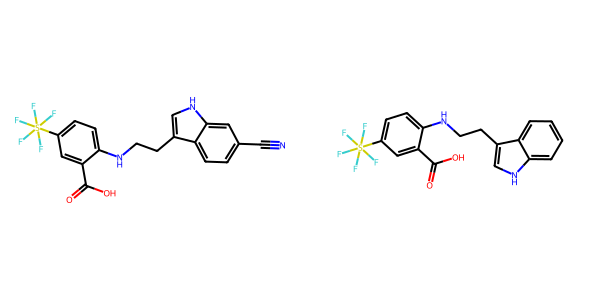

In [ ]:
ligand_scaffolds = [scaffold(mol) for mol in ligand_mols]
invalid_scaffolds = [mol for mol,scaffold in zip(ligand_mols,ligand_scaffolds) if scaffold == None]

Draw.MolsToGridImage(invalid_scaffolds, molsPerRow=2, subImgSize=(300,300))

There is no reason these structures should be excluded from the resulting set of scaffolds. Therefore, I will manually replace two of the six fluorine atoms with an empty string resulting in the sulfur having valence of 4 which is valid and then run it through scaffold generator again.

In [703]:
ligand_smiles = [Chem.MolToSmiles(mol) for mol in ligand_mols]
replaced_sf6 = [mol.replace("(F)(F)","") for mol in ligand_smiles]
replaced_ligand_mols = [Chem.MolFromSmiles(mol) for mol in replaced_sf6]
ligand_scaffolds_replaced = [scaffold(mol) for mol in replaced_ligand_mols]

Now generate smiles from scaffolds and enumerate them. The indices will be used for calculating the total count of each distinct scaffold.

In [716]:
scaffold_smiles = [(idx,Chem.MolToSmiles(scaff)) for idx,scaff in enumerate(ligand_scaffolds_replaced)]

In [713]:
index2scaffold = {}
for idx,smiles in scaffold_smiles:
    index2scaffold[smiles] = []

for idx,smiles in scaffold_smiles:
    index2scaffold[smiles].append(idx)

Calculate the total count of each distinct scaffold and sort them in an descending order according to occurrence.

In [714]:
scaffold_count = [(scaffold, len(index)) for scaffold, index in index2scaffold.items()]
scaffold_count.sort(key=lambda x: x[1], reverse=True)

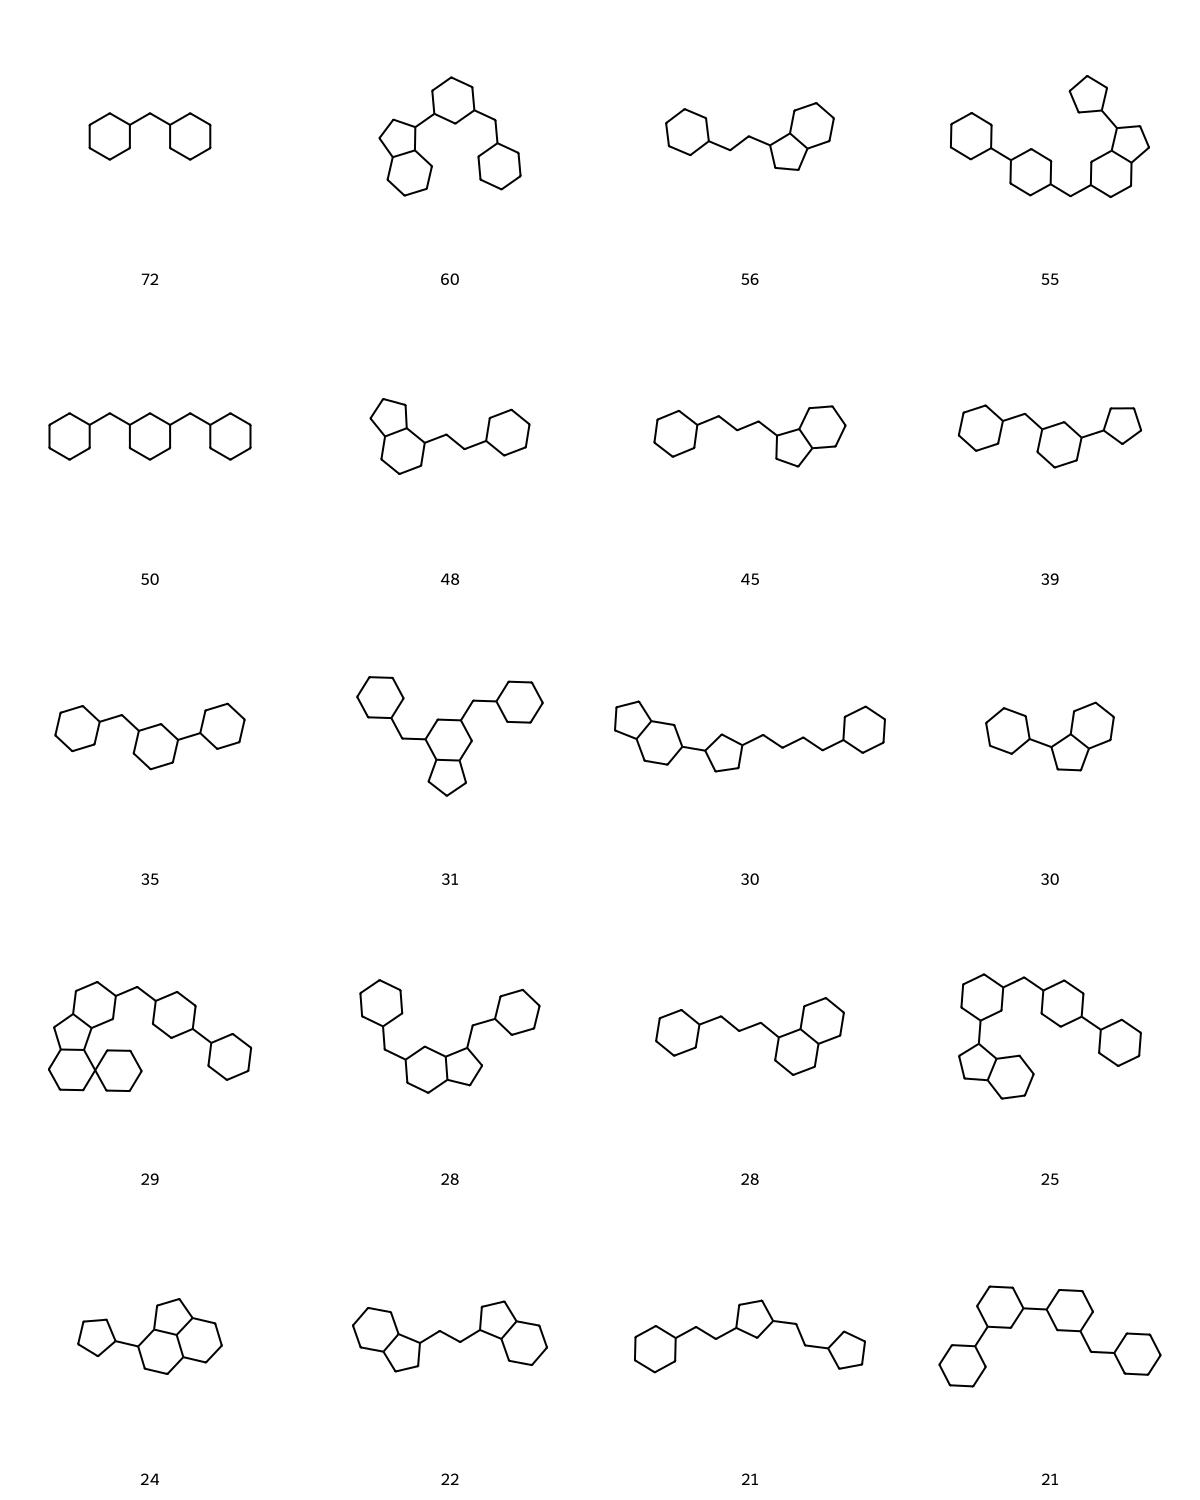

In [717]:
Draw.MolsToGridImage([Chem.MolFromSmiles(scaffold) for scaffold,_ in scaffold_count[:20]],
                     molsPerRow=4, subImgSize=(300,300),
                     legends=[str(count) for _, count in scaffold_count[:20]])

# VISUALIZATION OF CHEMICAL SPACE


Start by importing and loading a new data corresponding to chembl203 target. Perform the same data preprocessing steps as for chembl301 initial target.

In [ ]:
chembl301 = chembl
DATA203 = "CHEMBL203_ic50.csv"
chembl203 = pd.read_csv(DATA203,delimiter=";")
chembl203.drop_duplicates(subset="Smiles",inplace=True)
chembl203.dropna(subset="Smiles",inplace=True)

float_pattern = re.compile("[0-9]+(\.[0-9]*)?")

<>:10: SyntaxWarning: invalid escape sequence '\.'
<>:10: SyntaxWarning: invalid escape sequence '\.'
C:\Users\marti\AppData\Local\Temp\ipykernel_6576\3051606902.py:10: SyntaxWarning: invalid escape sequence '\.'
  float_pattern = re.compile("[0-9]+(\.[0-9]*)?")


Generate new columns and populate them accordingly. Column rdmol comprises RDKit structure objects, column fps comprses morgan fingerprints.

In [262]:
for idx,row in chembl301.iterrows():
    chembl301.loc[idx,"rdmol"] = Chem.MolFromSmiles(row["Smiles"])
    chembl301.loc[idx,"smiles"] = row["Smiles"]
    chembl301.loc[idx,"source"] = "cdk2"
    chembl301.loc[idx,"fps"] = Chem.GetMorganFingerprintAsBitVect(chembl301.loc[idx,"rdmol"],2,nBits=1024)

[10:56:19] DEPRECATION WARNING: please use MorganGenerator
C:\Users\marti\AppData\Local\Temp\ipykernel_6576\515249915.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x00000236E8FBB6F0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  chembl301.loc[idx,"fps"] = Chem.GetMorganFingerprintAsBitVect(chembl301.loc[idx,"rdmol"],2,nBits=1024)
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DE

[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerator
[10:56:19] DEPRECATION WARNING: please use MorganGenerat

Do the same column generation for the other dataset as well.

In [263]:
for idx,row in chembl203.iterrows():
    chembl203.loc[idx,"rdmol"] = Chem.MolFromSmiles(row["Smiles"])
    chembl203.loc[idx,"smiles"] = row["Smiles"]
    chembl203.loc[idx,"source"] = "egfr"
    chembl203.loc[idx,"fps"] = Chem.GetMorganFingerprintAsBitVect(chembl203.loc[idx,"rdmol"],2,nBits=1024)

[10:56:21] DEPRECATION WARNING: please use MorganGenerator
C:\Users\marti\AppData\Local\Temp\ipykernel_6576\941437595.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x000002363CD349E0>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  chembl203.loc[idx,"fps"] = Chem.GetMorganFingerprintAsBitVect(chembl203.loc[idx,"rdmol"],2,nBits=1024)
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DEPRECATION WARNING: please use MorganGenerator
[10:56:21] DE

Concatenate the two dataset into one and splice all the columns except the ones previously generated.

In [ ]:
df_concated = pd.concat([chembl203,chembl301],ignore_index=True)
df_calculated = pd.DataFrame(df_concated, columns=["rdmol","smiles","source","fps"])

df_calculated.reset_index(level=0, inplace=True)
df_calculated

,index,rdmol,smiles,source,fps
0,0,<rdkit.Chem.rdchem.Mol object at 0x000002363CD...,COc1cc2c(Nc3ccc(Cl)cc3F)ncnc2cc1OCC1CCN(C)CC1.Cl,egfr,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,Cl.Nc1ccc2c(c1)sc1c(Nc3cccc(Br)c3)ncnc12,egfr,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,Cl.O=[N+]([O-])c1cccc2c1sc1c(Nc3cccc(Br)c3)ncnc12,egfr,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,CN(C)CCOc1cc2c(Nc3cccc(Br)c3)c(C#N)cnc2cn1,egfr,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, ..."
4,4,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,O=CNN1C(=O)c2c(c3c4cccc(O)c4n(C4OC(CO)C(O)C(O)...,egfr,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...,...,...
13690,13690,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,CN(C)C/C=C/C(=O)Nc1ccc(C(=O)Nc2cccc(Nc3ncc(Cl)...,cdk2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13691,13691,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,CC(C)c1c2cc(-c3ccnc(N[C@H]4CC[C@H](NC5CCOCC5)C...,cdk2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
13692,13692,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,CC(C)CC(=O)Nc1n[nH]c2c1CN(C(=O)C1CCN(C)CC1)C2(C)C,cdk2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13693,13693,<rdkit.Chem.rdchem.Mol object at 0x00000236988...,COc1cc2ncn(-c3cc(OCc4ccccc4C(F)(F)F)c(C(N)=O)s...,cdk2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Define more descriptors using Lipinski package.

In [ ]:
lip_func = [("HBA", lp.NumHAcceptors), ("HBD", lp.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", lp.NumRotatableBonds)]

Calculate these descriptors for each molecule in the concatenated dataset

In [ ]:
for name,function in lip_func:
    df_calculated[name] = df_calculated["rdmol"].apply(function)

Upon that calculate even more additional descriptors, now MQN (molecular quantum numbers, DOI: 10.1002/cmdc.200900317) descriptors for each molecule in the dataset.

In [267]:
df_mqn = df_calculated.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df_calculated["rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

Perform PCA on normalized (l2) MQN descriptors and append the PCA coordinated for every PC to the dataframe

In [ ]:
pca = PCA(n_components=42)
norm = preprocessing.normalize(df_mqn[(f"MQN_{x}" for x in range(1, 43))])
pca.fit(norm)
df_normalized_pca = df_mqn.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]))

Chemical space visualization of the cdk2 and egfr datasets displayed using seaborn library. It is easy to observe the two datasets are kind of alike covering similar space, with the cdk2 dataset being smaller and thus covering only a subspace.

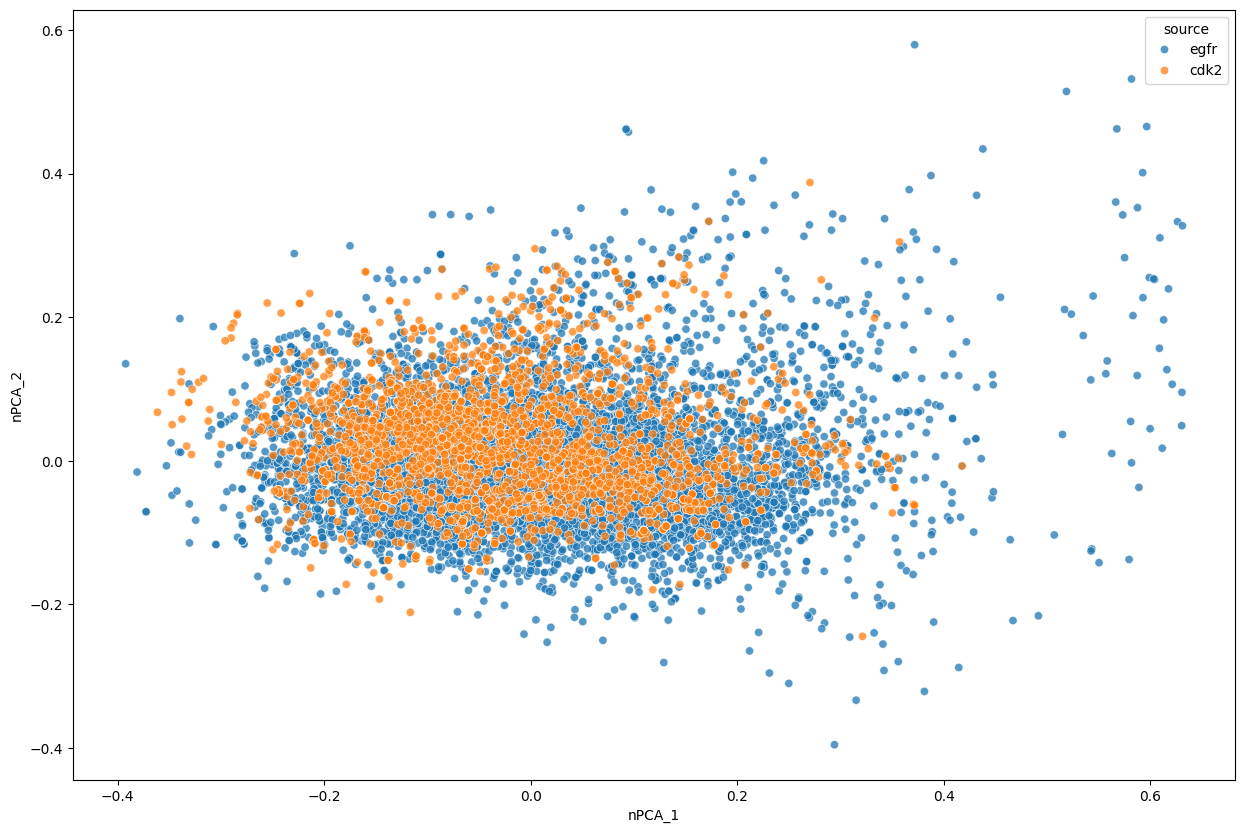

In [728]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="nPCA_1",
                      y="nPCA_2",
                      data=df_normalized_pca,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

Perform chemical space visualization using tsne now based on fingerprints.

In [ ]:
sparse_mat = distance.pdist(list(df_normalized_pca["fps"]),metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

clf = manifold.TSNE(n_components=2, metric="precomputed", init="random")
X_tsne = clf.fit_transform(dist_mat)

In [273]:
df_tsne = df_normalized_pca.join(pd.DataFrame(X_tsne, columns=["tsne_x","tsne_y"]))

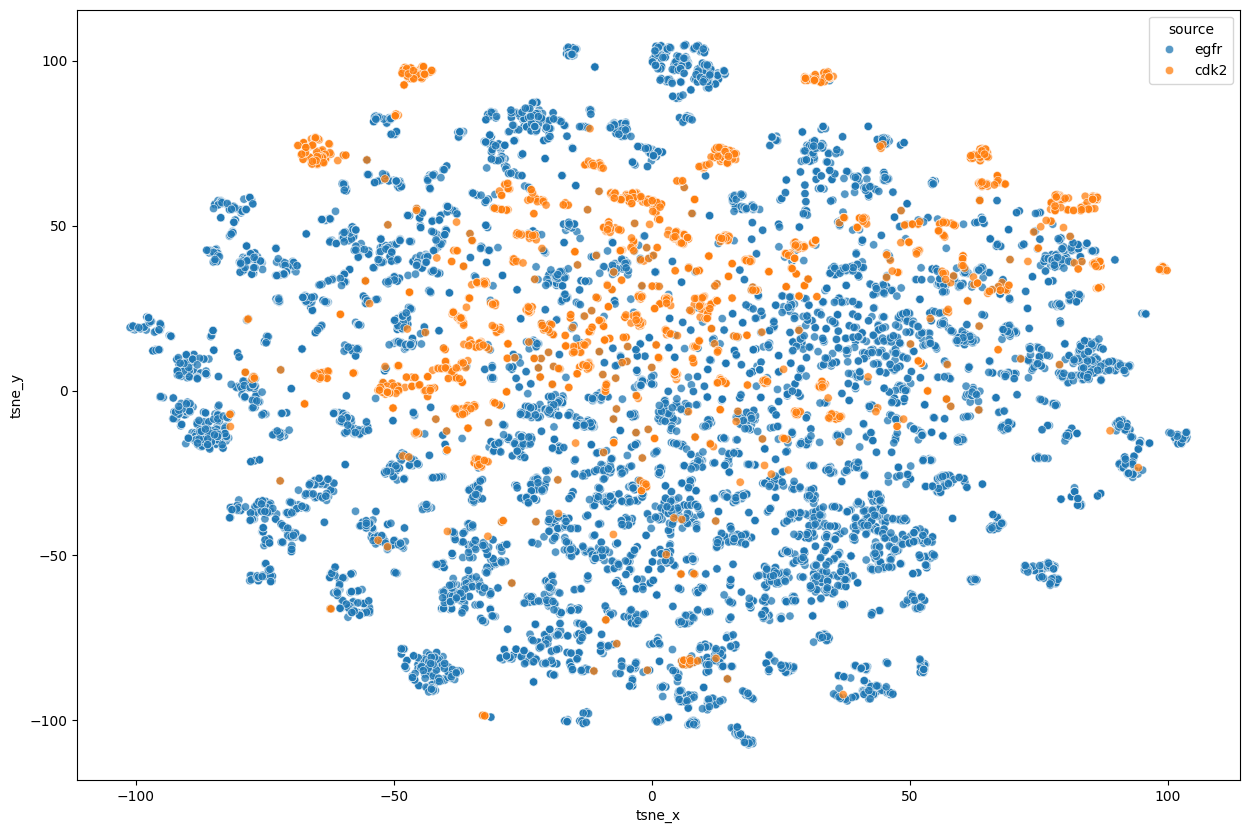

In [274]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="tsne_x",
                      y="tsne_y",
                      data=df_tsne,
                      hue="source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )

# MODELLING


First remove possible salts and neutralize all charges.

In [ ]:
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [643]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

Import data using csv.DictReader. The previous approach using pandas.read_csv resulted in numerous errors due to nan values present in the dataset.

In [ ]:
with open(DATA) as data:
    chembl301 = [row for row in csv.DictReader(data, delimiter=";", quotechar='"')]
    for row in chembl301:
        mol = Chem.MolFromSmiles(row["Smiles"])
        if mol:
            row["rdmol"] = mol
            stdmol = standardize(mol)
            row["pChEMBL Value"] = float(row["pChEMBL Value"]) if float_pattern.match(row["pChEMBL Value"]) else 0
            row["std_rdmol"] = None
        if stdmol:
            row["std_rdmol"] = stdmol

<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
C:\Users\marti\AppData\Local\Temp\ipykernel_6576\2816410189.py:4: SyntaxWarning: invalid escape sequence '\.'
  float_pattern = re.compile("[0-9]+(\.[0-9]*)?")


Create a dataframe from the read data and select only relevant columns for the next assignment

In [645]:
chembl301 = pd.DataFrame([row for row in chembl301 if row["std_rdmol"]])
chembl301 = chembl301[["Smiles", "rdmol", "std_rdmol", "pChEMBL Value"]]
chembl301.reset_index(level=0, inplace=True)

Calculate MQN descriptors

In [646]:
chembl301_mqn = chembl301.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in chembl301["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )

Split the dataset into a test a train set only for valid pChEMBL values (those greater than 0)

In [647]:
trainset, testset = train_test_split(chembl301_mqn[chembl301_mqn["pChEMBL Value"] > 0],train_size=0.6)

Define a simple evaluation criterium, basically a MAE

In [648]:
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[predicted_value])
    res.columns = ["Prediction", predicted_value]
    print(f"Average error cdk2: {(res["Prediction"]-res[predicted_value]).abs().mean()}")
    return res

In [649]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

Pick a model to train, I picked a random forest regressor with default choice of hyperparameters. Of course, the hyperparameters can be tuned so the performance and predictive ability of the model are fine-tuned but there was no time for this.

In [650]:
model_rf = ensemble.RandomForestRegressor()
model_rf.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

RandomForestRegressor()

Calculate the MAE using get_results function which also returns a dataframe object with two columns comprising predicted and real target variable values

In [659]:
print("Train data")
train_results = get_results(model_rf, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")
print("Test data")
test_results = get_results(model_rf, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Train data
Average error cdk2: 0.2770292623189291
Test data
Average error cdk2: 0.6167779052118053


Plot the predicted values vs real values of target variable. The scatterplot should follow the trend of a rendered red line (see below). Training data seems to follow it well.

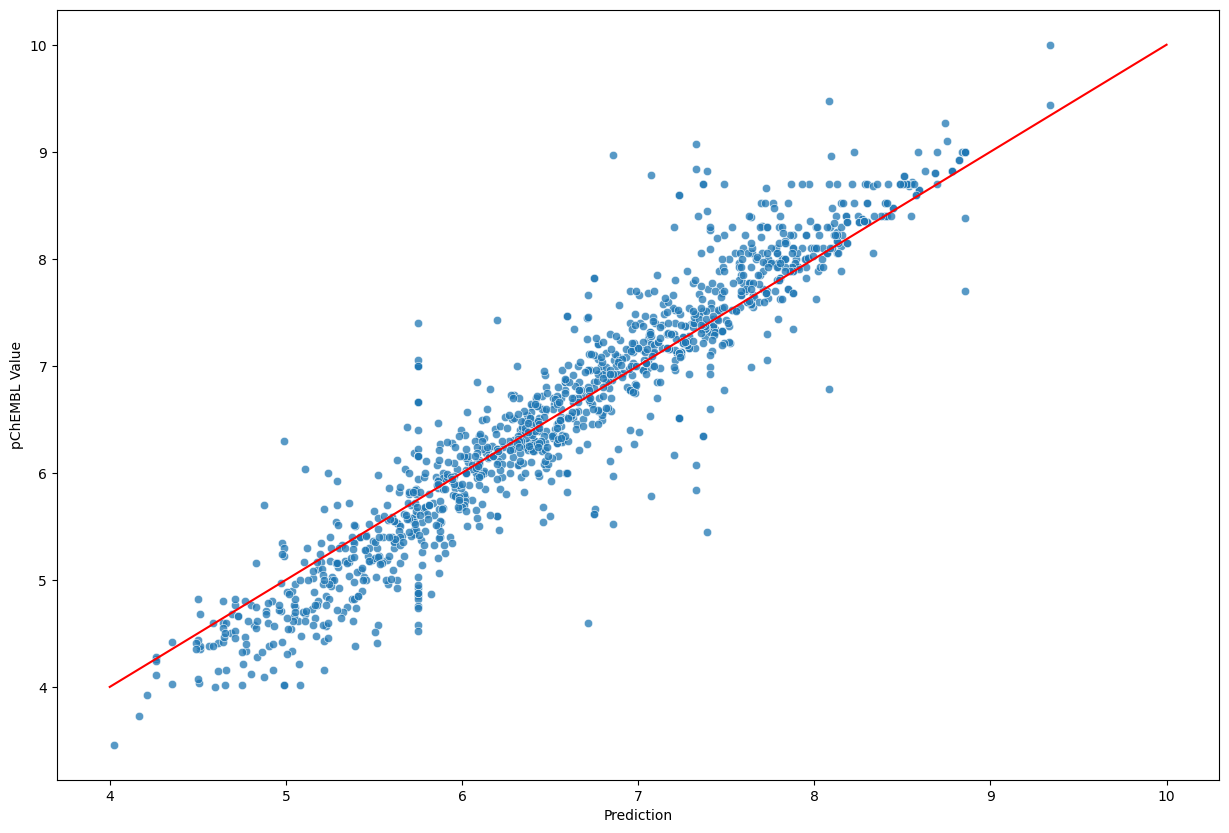

In [657]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
plt.plot([4,10], [4,10], color='r')
plt.show()

Testing data is a bit worse but that is to be expected. This corresponds to the calculated value of MAE before. However, the trend of the prediction vs. real value of target variable is still valid and follows the red line.

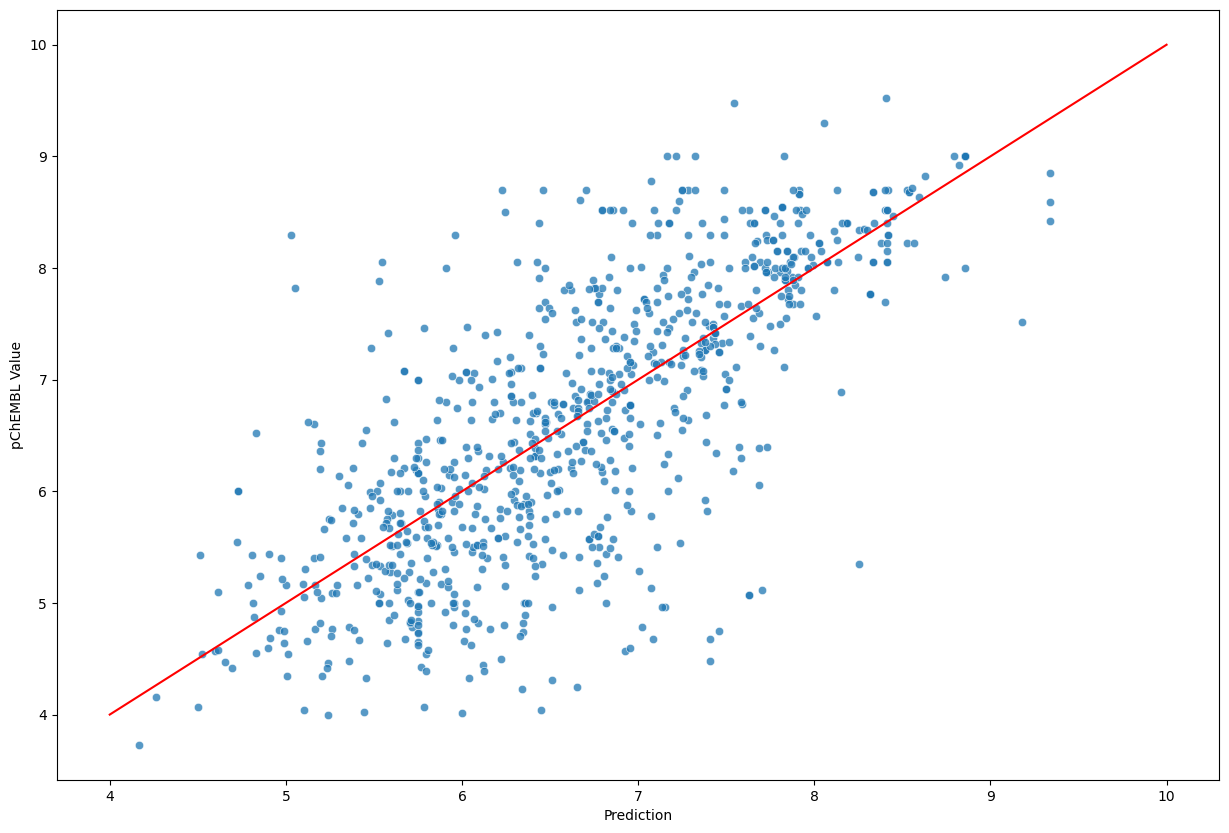

In [658]:
fig, ax = plt.subplots(figsize=(15,10))
p=sns.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
plt.plot([4,10], [4,10], color='r')
plt.show()